In [4]:
import os
import ray


In [5]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [6]:
if ray.is_initialized():
    ray.shutdown()

ray.init()

2024-10-19 18:46:27,635	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [7]:
ray.cluster_resources()

{'object_store_memory': 1731246489.0,
 'CPU': 8.0,
 'node:127.0.0.1': 1.0,
 'node:__internal_head__': 1.0,
 'memory': 3462492980.0}

In [8]:
num_workers = 1
resources_per_worker = {"CPU": 4, "GPU": 0}

In [12]:

# Storage
EFS_DIR = f"/efs/shared_storage/documentclasifier/{os.environ['GITHUB_USERNAME']}"
print (EFS_DIR)

/efs/shared_storage/documentclasifier/Pav-03


# Data

## Data Ingestion

In [14]:
import pandas as pd

In [19]:
DATASET_LOC = "https://github.com/Pav-03/Document-Classifier/raw/refs/heads/main/Datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## Data Spilliting 

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [25]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [26]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [27]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## EDA

In [28]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [29]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

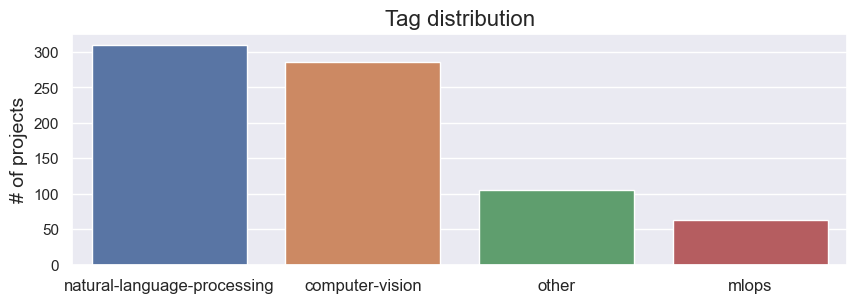

In [30]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

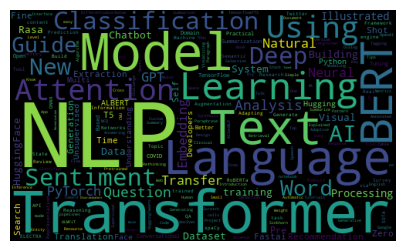

In [31]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

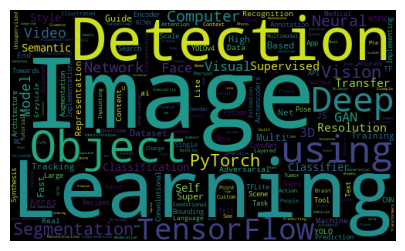

In [32]:
# Most frequent tokens for each tag
tag="computer-vision"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

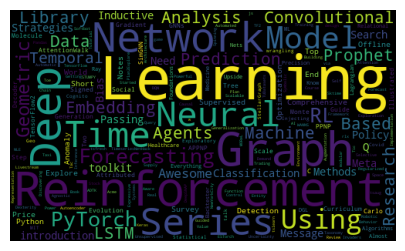

In [33]:
# Most frequent tokens for each tag
tag="other"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

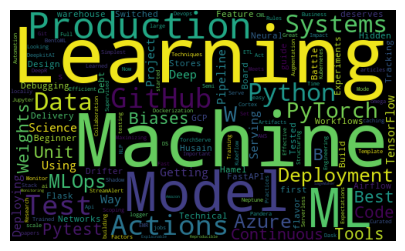

In [34]:
# Most frequent tokens for each tag
tag="mlops"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

## Data Pre-Processing

In [35]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [36]:
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [37]:
# Feature engineering

df["text"] = df.title + " " + df.description

In [38]:
df.head()

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,Awesome Monte Carlo Tree Search A curated list...
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other,"AttentionWalk A PyTorch Implementation of ""Wat..."


In [39]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pavanmodi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [40]:
def clean_text(text,stopwords = STOPWORDS):

    """ Clean raw text strings."""

    #Lower
    text = text.lower()

    #Remove stopwords
     # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [41]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)

print (f"{ original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


## Clean Dataframe

In [42]:
#DataFrame Cleanup

df.drop(columns = ["id", "created_on", "title", "description"], errors = "ignore")
df.dropna(subset = ["tag"]) #drop nulls
df = df[["text","tag"]] #rearrange cols

df.head()


,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


## Lable Encoding

In [44]:
#label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag : i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [47]:
#Encode Labels
df["tag"] = df["tag"].map(class_to_index)

In [48]:
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [50]:
def decode (indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [51]:
index_to_class = {v: k for k, v in class_to_index.items()}

decode(df.head()["tag"].values, index_to_class = index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

## Tokeniser

In [52]:
import numpy as np
from transformers import BertTokenizer

In [53]:
#Bert Tokeniser

tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [54]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors = "np", padding="longest")
    return dict(ids = encoded_inputs["input_ids"], masks = encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))


In [55]:
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

In [56]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [57]:
#Apply

preprocess(df=train_df , class_to_index = class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1